In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
print(data.shape)
data.head()

(70692, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [3]:
# Train/test split
train, test = train_test_split(data, test_size=0.2, random_state=21)
X_train, y_train = train.drop(columns = ['Diabetes_binary']), train['Diabetes_binary']
X_test, y_test = test.drop(columns = ['Diabetes_binary']), test['Diabetes_binary']
assert X_train.shape[0] == len(y_train)

In [4]:
#Feature Selection
#https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [5]:
sel.get_support()

array([ True, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
        True,  True,  True])

In [6]:
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

8

In [7]:
print(selected_feat)

Index(['HighBP', 'BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education',
       'Income'],
      dtype='object')


In [8]:
feature_columns = ['HighBP', 'BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
feature_data = data[feature_columns]
label_data = data['Diabetes_binary']

In [9]:
corr = feature_data.corr()
corr[np.abs(corr) < 0.2] = np.nan
print(corr)

             HighBP       BMI   GenHlth  MentHlth  PhysHlth       Age  \
HighBP     1.000000  0.241019  0.320540       NaN       NaN  0.338132   
BMI        0.241019  1.000000  0.267888       NaN       NaN       NaN   
GenHlth    0.320540  0.267888  1.000000  0.315077  0.552757       NaN   
MentHlth        NaN       NaN  0.315077  1.000000  0.380272       NaN   
PhysHlth        NaN       NaN  0.552757  0.380272  1.000000       NaN   
Age        0.338132       NaN       NaN       NaN       NaN  1.000000   
Education       NaN       NaN -0.285420       NaN       NaN       NaN   
Income          NaN       NaN -0.382969 -0.219070 -0.279326       NaN   

           Education    Income  
HighBP           NaN       NaN  
BMI              NaN       NaN  
GenHlth    -0.285420 -0.382969  
MentHlth         NaN -0.219070  
PhysHlth         NaN -0.279326  
Age              NaN       NaN  
Education   1.000000  0.460565  
Income      0.460565  1.000000  


In [10]:
#Finding the Best n_estimators by Grid Search
param_test1 = {
    'n_estimators': range(10, 71, 10)
}

model = GridSearchCV(
    estimator=RandomForestRegressor(min_samples_split=100, min_samples_leaf=20, max_depth=8, max_features='sqrt', random_state=10),
    param_grid=param_test1, 
    cv=5,
    scoring='neg_mean_squared_error'  
)

model.fit(X_train, y_train)

best_params = model.best_params_
best_score = np.sqrt(-model.best_score_)
print(f"Best RMSE from GridSearchCV: {best_score}")
print(f"Best Parameters: {best_params}")

y_pred = model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {test_rmse}")

Best RMSE from GridSearchCV: 0.41392424885747686
Best Parameters: {'n_estimators': 70}
Test RMSE: 0.4144767366066286


In [11]:
#Adjusting max_depth and min_samples_split
param_test2 = {
    'max_depth': range(3, 14, 2),
    'min_samples_split': range(50, 201, 20)
}

model = GridSearchCV(
    estimator=RandomForestRegressor(n_estimators=70, min_samples_leaf=20, max_features='sqrt', oob_score=True, random_state=10),
    param_grid=param_test2, 
    cv=5,
    scoring='neg_mean_squared_error'  
)

model.fit(X_train, y_train)

best_params = model.best_params_
best_score = np.sqrt(-model.best_score_) 
print(f"Best RMSE from GridSearchCV: {best_score}")
print(f"Best Parameters: {best_params}")

y_pred = model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {test_rmse}")

Best RMSE from GridSearchCV: 0.4111461706661537
Best Parameters: {'max_depth': 13, 'min_samples_split': 50}
Test RMSE: 0.41090964818262915


In [12]:
#Adjusting min_samples_leaf and min_samples_split
param_test3 = {
    'min_samples_split': range(10, 90, 20),
    'min_samples_leaf': range(10, 60, 10),
}

model = GridSearchCV(
    estimator=RandomForestRegressor(n_estimators=70, max_depth=13, max_features='sqrt', oob_score=True, random_state=10),
    param_grid=param_test3, 
    cv=5,
    scoring='neg_mean_squared_error'  
)

model.fit(X_train, y_train)


best_params = model.best_params_
best_score = np.sqrt(-model.best_score_)  
print(f"Best RMSE from GridSearchCV: {best_score}")
print(f"Best Parameters: {best_params}")


y_pred = model.predict(X_test)

# 计算并打印测试集上的RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {test_rmse}")

Best RMSE from GridSearchCV: 0.41059298483883055
Best Parameters: {'min_samples_leaf': 10, 'min_samples_split': 30}
Test RMSE: 0.4105336025023213


In [15]:
#Adjusting max_features
param_test4 = {
    'max_features': range(3, 9, 2),
}

model = GridSearchCV(
    estimator=RandomForestRegressor(n_estimators=70, max_depth=13, min_samples_split=30, min_samples_leaf=10, oob_score=True, random_state=10),
    param_grid=param_test4, 
    cv=5,
    scoring='neg_mean_squared_error'
)

model.fit(X_train, y_train)

best_params = model.best_params_
best_score = np.sqrt(-model.best_score_)  
print(f"Best RMSE from GridSearchCV: {best_score}")
print(f"Best Parameters: {best_params}")

y_pred = model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {test_rmse}")

Best RMSE from GridSearchCV: 0.41038395517038334
Best Parameters: {'max_features': 5}
Test RMSE: 0.41017521776549354


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

model = RandomForestClassifier(n_estimators=70, max_depth=13, min_samples_split=30, 
                               min_samples_leaf=10, max_features=5)
model.fit(X_train, y_train)

pred_labels = model.predict(X_test)

acc_score = accuracy_score(y_test, pred_labels)
pre_score = precision_score(y_test, pred_labels)
rec_score = recall_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)
report = classification_report(y_test, pred_labels)

print(f"Accuracy: {acc_score}")
print(f"Precision: {pre_score}")
print(f"Recall: {rec_score}")
print(f"F1 Score: {f1}")
print(f"Classification Report:\n{report}")


Accuracy: 0.7474361694603578
Precision: 0.7278982214721537
Recall: 0.7917255012708274
F1 Score: 0.7584714237402772
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.70      0.74      7057
         1.0       0.73      0.79      0.76      7082

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



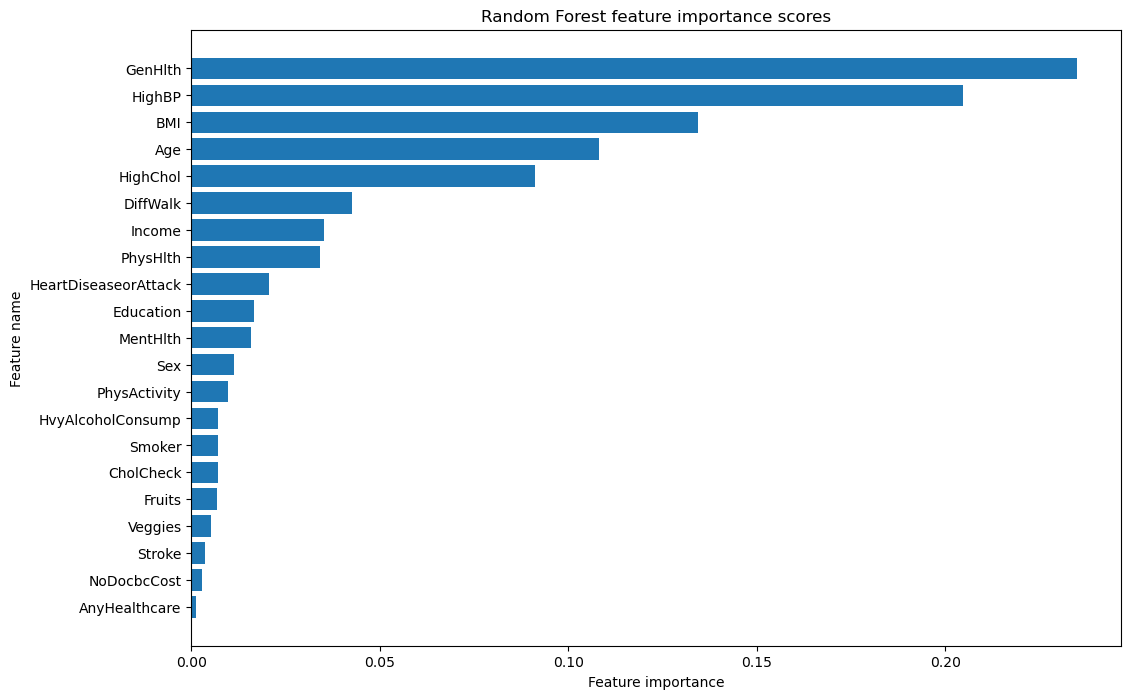

In [19]:
# Random Forest feature importance scores
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)

# Create a DataFrame to hold feature names and their importance scores
importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importances = importances.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(importances['Feature'], importances['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Feature importance')
plt.ylabel('Feature name')
plt.title('Random Forest feature importance scores')
plt.show()

In [20]:
# Rounding the importance scores to four decimal places
importances_rounded = importances.copy()
importances_rounded['Importance'] = importances_rounded['Importance'].round(4)
importances_rounded

,Feature,Importance
GenHlth,GenHlth,0.2349
HighBP,HighBP,0.2047
BMI,BMI,0.1343
Age,Age,0.1082
HighChol,HighChol,0.0910
DiffWalk,DiffWalk,0.0426
Income,Income,0.0351
PhysHlth,PhysHlth,0.0342
HeartDiseaseorAttack,HeartDiseaseorAttack,0.0205
Education,Education,0.0166
